# DATA PREPROCESSING AND FEATURE ENGINEERING  
# MODEL COMPARISION

### SETUP
<hr>

In [2]:
import pandas as pd
import numpy as np
import random 
import itertools 
from zipfile import ZipFile, Path

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image


%matplotlib inline

In [3]:
#!pip3installtorch

### GET DATA
<hr>

In [4]:
def get_data():
    with ZipFile("covtype.zip") as myzip:
        data = myzip.open("covtype.csv")
        df = pd.read_csv(data)

    return df

In [5]:
def reverse_encode(relevant_subset):
    '''
    This function reverses one-hot encoding for into rank-encoded representations
    Parameters: an subset of relevant columns of the same type, which we are trying to reverse encode
    Output: a title-less list of the encoded variable in numerical data
    '''

    num_list =[]
    for i in relevant_subset.iloc:
        ix = 1
        for j in i:
            if j ==1:
                num_list.append(ix)
            else: 
                ix +=1
                
    print('The new list has the following elements: ' + str(set(num_list)))
    if relevant_subset.shape[0] == len(num_list):
        return num_list
    else: print('Error in compiling list: lengths of the two lists do not match.')


In [6]:
tree_df = get_data() # instantiate are tree dataframe
soil_df = tree_df.loc[:,'Soil_Type1':'Soil_Type40'] # define our soul subset dataframe
wilderness_df = tree_df.loc[:,'Wilderness_Area1':'Wilderness_Area4'] # define our wilderness subset dataframe
cont_df = tree_df.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points'] # dataframe of remaining, continuous variables

##### Reverse one-hot encode

By reverse one-hot-encoding the soil (40 different soil varialbes) and wilderness variables (4 different wilderness variables), we can combine these variables into a single 'soil' and single 'wildnerness' variable. This will help us assess the overall importance of the 'soil' and 'wildnerness' variables during feature selection.

In [7]:
# reverse one-hot-encode our soil and wilderness dataframes
w = reverse_encode(wilderness_df)
s = reverse_encode(soil_df)

The new list has the following elements: {1, 2, 3, 4}
The new list has the following elements: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}


In [8]:
# add our new features to the remaining, continuous varaiables dataframe
cont_df['Wilderness'] = w
cont_df['SoilType'] = s

forest_df = cont_df
#print(forest_df.head()) check if Wildnerness and SoilType variables are combined into single variable

<ipython-input-8-f4ba4ea86aa6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['Wilderness'] = w
<ipython-input-8-f4ba4ea86aa6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['SoilType'] = s


##### Scale data

Feature scaling is used to normalize the range of independent variables or features of data. This way, each feature has the same footing of one another without any upfront importance.

In [8]:
# scale our data (subtract mean and divide by standard deviation)
X_forest = preprocessing.scale(forest_df.values)

# combine our data so that we can split into train, test, val
X_forest_df = pd.DataFrame(X_forest, columns=[forest_df.columns])
X_forest_df['cov_type'] = tree_df.values[:, -1]
XY_forest_df = X_forest_df
print(XY_forest_df.shape)

(581012, 13)


In [9]:
# - split to train, val, test (70, 20, 10)
train, remainder = train_test_split(XY_forest_df, train_size=0.7)
val, test = train_test_split(remainder, test_size=0.33)

print(train.shape)
print(val.shape)
print(test.shape)

(406708, 13)
(116783, 13)
(57521, 13)


In [10]:
# convert each dataset to csv and compress
train.to_csv('../train.zip', compression = dict(method='zip', archive_name='train.csv'))
val.to_csv('../val.zip', compression = dict(method='zip', archive_name='val.csv'))
test.to_csv('../test.zip', compression = dict(method='zip', archive_name='test.csv'))

In [11]:
##### something like this will be used to access our data during model building #####
# with ZipFile("../train.zip") as myzip:
#     data = myzip.open("train.csv")
#     df = pd.read_csv(data)
#     df.drop(column=[0], axis = 1, inplace = True)
    
#     print(df)

### FEATURE SELECTION

We built a random forest model to calculate the importance of our features. This is done according to the feature's ability to increase the pureness of the leaves. The higher the increment in leaves purity, the higher the importance of the feature. This is done for each tree, then is averaged among all the trees and, finally, normalized to 1 (the sum of the importance scores calculated by a Random Forest is 1).

We also looked at the correlation between the variables. If variables are correlated with each other we felt more more comfortable removing one of features when model building.

We finally combined these two approaches to determine which features would be best to remove and reduce the dimensionality in the model.

<hr>

##### Get our datasets

In [12]:
with ZipFile("../train.zip") as myzip:
    data = myzip.open("train.csv")
    train_df = pd.read_csv(data)
    train_df.drop(train_df.columns[0], axis = 1, inplace = True)
    
with ZipFile("../val.zip") as myzip:
    data = myzip.open("val.csv")
    val_df = pd.read_csv(data)
    val_df.drop(val_df.columns[0], axis = 1, inplace = True)

with ZipFile("../test.zip") as myzip:
    data = myzip.open("test.csv")
    test_df = pd.read_csv(data)
    test_df.drop(test_df.columns[0], axis = 1, inplace = True)
    

In [13]:
x_train = train_df.values[:, :-1]
y_train  = train_df.values[:, -1]
x_val = val_df.values[:, :-1]
y_val  = val_df.values[:, -1]
x_test = test_df.values[:, :-1]
y_test  = test_df.values[:, -1]

##### Build random forest to get list of feature importance

In [14]:
# make a random forest model
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_val)
rf_acc = accuracy_score(rf_pred, y_val)

feat_rf = rf.feature_importances_
print("Our random forest classified {:0.2f}% of the of the trees correctly".format(rf_acc*100))


Our random forest classified 96.00% of the of the trees correctly


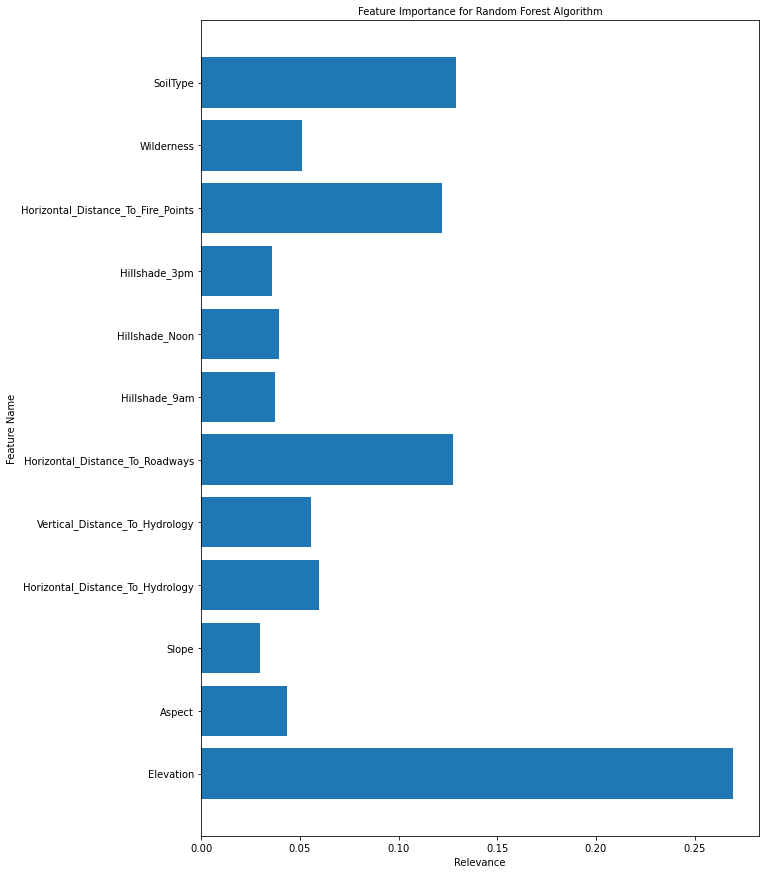

In [15]:
#plot feature importance
plt.figure(figsize=(10,15))
plt.barh(train_df.drop(columns='cov_type').columns.values, feat_rf)
plt.title('Feature Importance for Random Forest Algorithm',fontsize=10)
plt.ylabel('Feature Name')
plt.xlabel('Relevance')
plt.show()



Above is a bar chart showing how important the random forest algorithm found the features in making predictions. Elevation, Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points, and SoilType have higher importance. The 3 Hillshade variables and 'Slope' have lower importance. 

##### Perform Correlation Analysis

<AxesSubplot:xlabel='None', ylabel='None'>

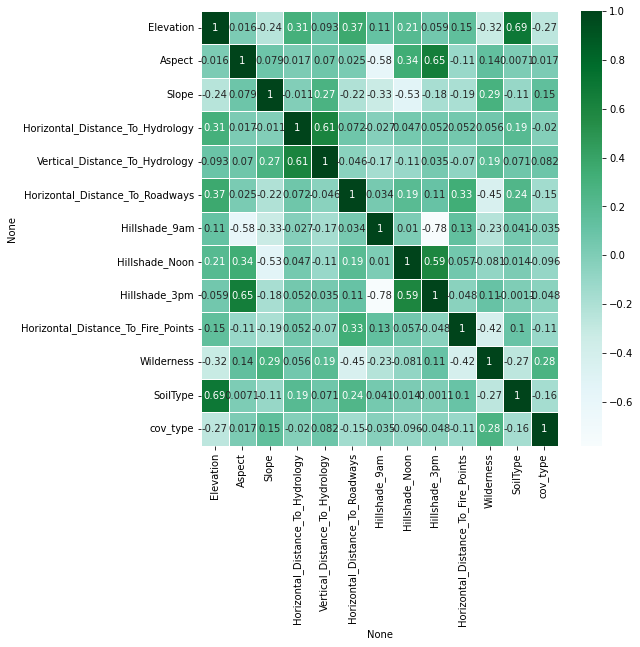

In [16]:
correlation = XY_forest_df.corr()

plt.figure(figsize=(8,8))

sns.heatmap(correlation,
            cmap='BuGn',
            linecolor='white',
            linewidths=1,
            annot=True, 
            xticklabels = True,
            yticklabels= True)


Above is a chart showing the correlations for the variables. Hillshade_Noon is correlated with Hillshade_3pm, Elevation is correlated with SoilType.

### CONCLUSIONS AND RECOMMENDATIONS
<hr>

When looking at the features’ correlation and relevance to the model, we recommend dropping column 'Hillshade_3pm’.  Our reasoning is:

1. The variable is strongly correlated with 'Hillshade_Noon' and the Aspect column. Therefore we feel like this additional feature will not bring additional information and increase the complexity of the model
2. The variable has low relevance to the model

##### Check to see if model performance increased after feature selection

In [17]:
train_df2 = train_df.drop(columns='Hillshade_3pm')
val_df2 = val_df.drop(columns='Hillshade_3pm')
test_df2 = test_df.drop(columns='Hillshade_3pm')

x_train2 = train_df2.values[:, :-1]
y_train2  = train_df2.values[:, -1]
x_val2 = val_df2.values[:, :-1]
y_val2  = val_df2.values[:, -1]
x_test2 = test_df2.values[:, :-1]
y_test2  = test_df2.values[:, -1]

rf2 = RandomForestClassifier()
rf2.fit(x_train2, y_train2)
rf_pred2 = rf2.predict(x_val2)
rf_acc2 = accuracy_score(rf_pred2, y_val2)

print("Our random forest classified {:0.2f}% of the of the trees correctly".format(rf_acc2*100))

In [ ]:
#!pip install mlxtend

#After removing the 'Hillshade_3pm’ feature, the model increased its accuracy by .18pp.

### GridSearchCV
GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters

### Data Transformation Techniques:
- StandardScaler follows Standard Normal Distribution (SND). Therefore, it makes mean = 0 and scales the data to unit variance. 
- MinMaxScaler scales all the data features in the range [0, 1] or else in the range [-1, 1] if there are negative values in the dataset

### PCA:
Principal component analysis (PCA) simplifies the complexity in high-dimensional data while retaining trends and patterns. It does this by transforming the data into fewer dimensions, which act as summaries of features.

In [130]:
model_df = pd.DataFrame(columns =["model_name","model_type","time_taken","f1_score"])

In [281]:
# This is a function that generates ML Models of various types that we are interested in
# The Params are chosen based on experimentation we conducted earlier

def  Model_Function(modelType = "KNeighborsClassifier",option = None, ):
    msg_txt = modelType
    global model_df
    if modelType== "KNeighborsClassifier":
            model = KNeighborsClassifier()
            grd_model = GridSearchCV( model ,  param_grid =  {'n_neighbors': [3]},return_train_score =  1, 
                                     cv=3, n_jobs=-1)
    elif modelType== "LogisticRegression":
            model = LogisticRegression()
            grd_model = GridSearchCV( LogisticRegression(max_iter=1000, random_state=1, solver='newton-cg', tol=0.001) ,  
                                     param_grid =  {'C': [0.1, 1.0, 100.0]},return_train_score =  1, cv=3, n_jobs=-1)

    elif modelType== "DecisionTreeClassifier":
            model = DecisionTreeClassifier()
            grd_model = GridSearchCV( DecisionTreeClassifier(random_state=1) ,  
                                     param_grid =  {'max_depth': [5, 15, 30, 50]},return_train_score =  1, cv=3, n_jobs=-1)

    elif modelType== "RandomForestClassifier":
            model = RandomForestClassifier()
            grd_model = model
#    elif modelType== "GradientBoosting":
#            model = KNeighborsClassifier()
    elif modelType== "NeuralNetwork":
            model = MLModel(modelName=model_type['modelName'])
            grd_model = GridSearchCV( MLPClassifier(random_state=1),  
                                     param_grid =  {'hidden_layer_sizes': [(50,), (50, 20), (100,), (100, 20)]},
                                     return_train_score =  1 , cv=3, n_jobs=-1)
            
    X_train = train_data
    X_dev = dev_data
    start = time. time()
    if modelType == "KNeighborsClassifier":
        if option == None:
            print("Creating model_df Dataframe")
            model_df = pd.DataFrame(columns =["model_name","model_type","time_taken","f1_score","Predicted"])

    if option == None:
        msg_txt += " With No Transformation "
        grd_model.fit(X_train,train_labels)
        predicted= grd_model.predict(X_dev)
    elif option == "Scaler":
        msg_txt += " With Scaler_type 'MinMax' Transformation"
        print("scaler_type : MinMax")
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_dev = scaler.transform(X_dev)
        grd_model.fit(scaled_X_train,train_labels)
        predicted= grd_model.predict(scaled_X_dev)
    elif option == "PCA":
        msg_txt += " With PCA Transformation "
        var_threshold=0.95
        pca = PCA(n_components=X_train.shape[1])
        pca.fit(X_train)
        df_pca = pd.DataFrame()
        df_pca['NumPrinComponents'] = np.arange(start=1 , stop=X_train.shape[1])
        df_pca['ExplainedVariance'] = pd.Series(pca.explained_variance_ratio_)
        df_pca['CumExplainedVariance'] = pd.Series(np.cumsum(pca.explained_variance_ratio_))
        npca = df_pca.loc[df_pca.CumExplainedVariance > var_threshold,:].NumPrinComponents.iloc[0]
        pcaModel = PCA(n_components=npca)
        X_train_pca = pcaModel.fit_transform(X_train)
        X_dev_pca = pcaModel.transform(X_dev)
        grd_model.fit(X_train_pca,train_labels)
        predicted= grd_model.predict(X_dev_pca)
    end = time. time()
    duration = end - start
    print ( "\033[1m" ,   msg_txt , "\033[0;0m" )
    if modelType != "RandomForestClassifier":
        print ("Best fit parameters : ", grd_model.best_params_)
    print ("Best fit model F1 score : ", metrics.f1_score(dev_labels, predicted , average='micro'))
    print ("Duration : ", duration)
    print("Predicted: ", predicted)
    print("Predicted Shape: ", predicted.shape)

    # Update Dataframe 
    my_df = {"model_name": modelType, "model_type":  option, "time_taken":duration, 
             "f1_score": metrics.f1_score(dev_labels, predicted , average='micro'), "predicted":predicted}
   
    model_df = model_df.append(my_df,ignore_index=True)
    #print(model_df)
    return model_df


In [282]:
# Now conduct experiment with various ML classifications and transformations
train_data = train_df2.values[:, :-1]
train_labels  = train_df2.values[:, -1]
dev_data = val_df2.values[:, :-1]
dev_labels  = val_df2.values[:, -1]
test_data = test_df2.values[:, :-1]
test_labels  = test_df2.values[:, -1]
total_start = time. time()
for classifier in ["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier","NeuralNetwork"]:
    print("Classifier: ", classifier)
    for option in [None, "Scaler", "PCA"]:
        print("Option: ", option)
        df =   Model_Function(modelType = classifier,option=option)
        print(df)
total_end = time. time()
print("Total Time Taken : ", total_end - total_start)


Classifier:  KNeighborsClassifier
Option:  None
Creating model_df Dataframe
 KNeighborsClassifier With No Transformation  
Best fit parameters :  {'n_neighbors': 3}
Best fit model F1 score :  0.9288937602219501
Duration :  47.64205718040466
Predicted:  [2. 1. 1. ... 1. 1. 2.]
Predicted Shape:  (116783,)
             model_name model_type  time_taken  f1_score  Predicted  \
0  KNeighborsClassifier       None   47.642057  0.928894        NaN   

                                           predicted  
0  [2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...  
Option:  Scaler
scaler_type : MinMax
 KNeighborsClassifier With Scaler_type 'MinMax' Transformation 
Best fit parameters :  {'n_neighbors': 3}
Best fit model F1 score :  0.9397086904772098
Duration :  53.58759570121765
Predicted:  [2. 1. 1. ... 1. 1. 2.]
Predicted Shape:  (116783,)
             model_name model_type  time_taken  f1_score  Predicted  \
0  KNeighborsClassifier       None   47.642057  0.928894        NaN   
1  KNeighborsClas

 RandomForestClassifier With No Transformation  
Best fit model F1 score :  0.9625716071688516
Duration :  56.01144981384277
Predicted:  [2. 1. 1. ... 1. 1. 2.]
Predicted Shape:  (116783,)
               model_name model_type  time_taken  f1_score  Predicted  \
0    KNeighborsClassifier       None   47.642057  0.928894        NaN   
1    KNeighborsClassifier     Scaler   53.587596  0.939709        NaN   
2    KNeighborsClassifier        PCA   38.031324  0.922960        NaN   
3      LogisticRegression       None  259.652602  0.712715        NaN   
4      LogisticRegression     Scaler  253.050701  0.712715        NaN   
5      LogisticRegression        PCA  279.875620  0.637987        NaN   
6  DecisionTreeClassifier       None    7.543110  0.931454        NaN   
7  DecisionTreeClassifier     Scaler    7.123512  0.931831        NaN   
8  DecisionTreeClassifier        PCA   15.335423  0.857591        NaN   
9  RandomForestClassifier       None   56.011450  0.962572        NaN   

       

C:\Users\savit\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 NeuralNetwork With No Transformation  
Best fit parameters :  {'hidden_layer_sizes': (100, 20)}
Best fit model F1 score :  0.8611270476011065
Duration :  907.3120393753052
Predicted:  [2. 1. 1. ... 1. 1. 2.]
Predicted Shape:  (116783,)
                model_name model_type  time_taken  f1_score  Predicted  \
0     KNeighborsClassifier       None   47.642057  0.928894        NaN   
1     KNeighborsClassifier     Scaler   53.587596  0.939709        NaN   
2     KNeighborsClassifier        PCA   38.031324  0.922960        NaN   
3       LogisticRegression       None  259.652602  0.712715        NaN   
4       LogisticRegression     Scaler  253.050701  0.712715        NaN   
5       LogisticRegression        PCA  279.875620  0.637987        NaN   
6   DecisionTreeClassifier       None    7.543110  0.931454        NaN   
7   DecisionTreeClassifier     Scaler    7.123512  0.931831        NaN   
8   DecisionTreeClassifier        PCA   15.335423  0.857591        NaN   
9   RandomForestClassif

C:\Users\savit\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 NeuralNetwork With Scaler_type 'MinMax' Transformation 
Best fit parameters :  {'hidden_layer_sizes': (100, 20)}
Best fit model F1 score :  0.8221059572026751
Duration :  4238.971682548523
Predicted:  [2. 1. 1. ... 1. 1. 2.]
Predicted Shape:  (116783,)
                model_name model_type   time_taken  f1_score  Predicted  \
0     KNeighborsClassifier       None    47.642057  0.928894        NaN   
1     KNeighborsClassifier     Scaler    53.587596  0.939709        NaN   
2     KNeighborsClassifier        PCA    38.031324  0.922960        NaN   
3       LogisticRegression       None   259.652602  0.712715        NaN   
4       LogisticRegression     Scaler   253.050701  0.712715        NaN   
5       LogisticRegression        PCA   279.875620  0.637987        NaN   
6   DecisionTreeClassifier       None     7.543110  0.931454        NaN   
7   DecisionTreeClassifier     Scaler     7.123512  0.931831        NaN   
8   DecisionTreeClassifier        PCA    15.335423  0.857591        NaN

C:\Users\savit\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 NeuralNetwork With PCA Transformation  
Best fit parameters :  {'hidden_layer_sizes': (100, 20)}
Best fit model F1 score :  0.8462190558557324
Duration :  678.3716814517975
Predicted:  [2. 1. 1. ... 1. 1. 2.]
Predicted Shape:  (116783,)
                model_name model_type   time_taken  f1_score  Predicted  \
0     KNeighborsClassifier       None    47.642057  0.928894        NaN   
1     KNeighborsClassifier     Scaler    53.587596  0.939709        NaN   
2     KNeighborsClassifier        PCA    38.031324  0.922960        NaN   
3       LogisticRegression       None   259.652602  0.712715        NaN   
4       LogisticRegression     Scaler   253.050701  0.712715        NaN   
5       LogisticRegression        PCA   279.875620  0.637987        NaN   
6   DecisionTreeClassifier       None     7.543110  0.931454        NaN   
7   DecisionTreeClassifier     Scaler     7.123512  0.931831        NaN   
8   DecisionTreeClassifier        PCA    15.335423  0.857591        NaN   
9   RandomFo

In [404]:
print (train_data.shape,dev_data.shape  , test_data.shape)

(406708, 11) (116783, 11) (57521, 11)


In [284]:
df.shape

(15, 6)

In [362]:
df_sorted = df.sort_values(by='f1_score', ascending=False)

In [363]:
df_plot = df

In [327]:
# Create X axis Label that is a combination of Shortened Model Name and Model Type
def modelLabel(row):  
    if row['model_name'] == "RandomForestClassifier" and row['model_type'] == 'Scaler':
        return 'RandForest-Scaler'
    elif row['model_name'] == "RandomForestClassifier" and row['model_type'] is None:
        return 'RandForest'
    elif row['model_name'] == "KNeighborsClassifier" and row['model_type'] is None:
        return 'KNeighbor'
    elif row['model_name'] == "KNeighborsClassifier" and row['model_type'] == "PCA":
        return 'KNeighbor-PCA'
    elif row['model_name'] == "KNeighborsClassifier" and row['model_type'] == "Scaler":
        return 'KNeighbor-Scaler'
    elif row['model_name'] == "DecisionTreeClassifier" and row['model_type'] is None:
        return 'DecisionTree'
    elif row['model_name'] == "DecisionTreeClassifier" and row['model_type'] == "PCA":
        return 'DecisionTree-PCA'
    elif row['model_name'] == "DecisionTreeClassifier" and row['model_type'] == "Scaler":
        return 'DecisionTree-Scaler'
    elif row['model_name'] == "NeuralNetwork" and row['model_type'] is None:
        return 'NeuralNetwork'
    elif row['model_name'] == "NeuralNetwork" and row['model_type'] == "PCA":
        return 'NeuralNetwork-PCA'
    elif row['model_name'] == "NeuralNetwork" and row['model_type'] == "Scaler":
        return 'NeuralNetwork-Scaler'
    elif row['model_name'] == "LogisticRegression" and row['model_type'] is None:
        return 'LogisticRegression'
    elif row['model_name'] == "LogisticRegression" and row['model_type'] == "PCA":
        return 'LogisticRegression-PCA'
    elif row['model_name'] == "LogisticRegression" and row['model_type'] == "Scaler":
        return 'LogisticRegression-Scaler'


In [328]:
df_sorted['xLabel'] = df_sorted.apply(lambda row: modelLabel(row), axis=1)


In [329]:
df_sorted.at[11,'xLabel']='RandForest-PCA'

In [366]:
df_plot

,model_name,model_type,time_taken,f1_score,Predicted,predicted,xLabel
0,KNeighborsClassifier,None,47.642057,0.928894,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...",KNeighbor
1,KNeighborsClassifier,Scaler,53.587596,0.939709,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...",KNeighbor-Scaler
2,KNeighborsClassifier,PCA,38.031324,0.922960,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...",KNeighbor-PCA
3,LogisticRegression,None,259.652602,0.712715,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 6.0, 1.0, ...",LogisticRegression
4,LogisticRegression,Scaler,253.050701,0.712715,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 6.0, 1.0, ...",LogisticRegression-Scaler
5,LogisticRegression,PCA,279.875620,0.637987,NaN,"[2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 6.0, 1.0, ...",LogisticRegression-PCA
6,DecisionTreeClassifier,None,7.543110,0.931454,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...",DecisionTree
7,DecisionTreeClassifier,Scaler,7.123512,0.931831,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...",DecisionTree-Scaler
8,DecisionTreeClassifier,PCA,15.335423,0.857591,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...",DecisionTree-PCA
9,RandomForestClassifier,None,56.011450,0.962572,NaN,"[2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...",RandForest


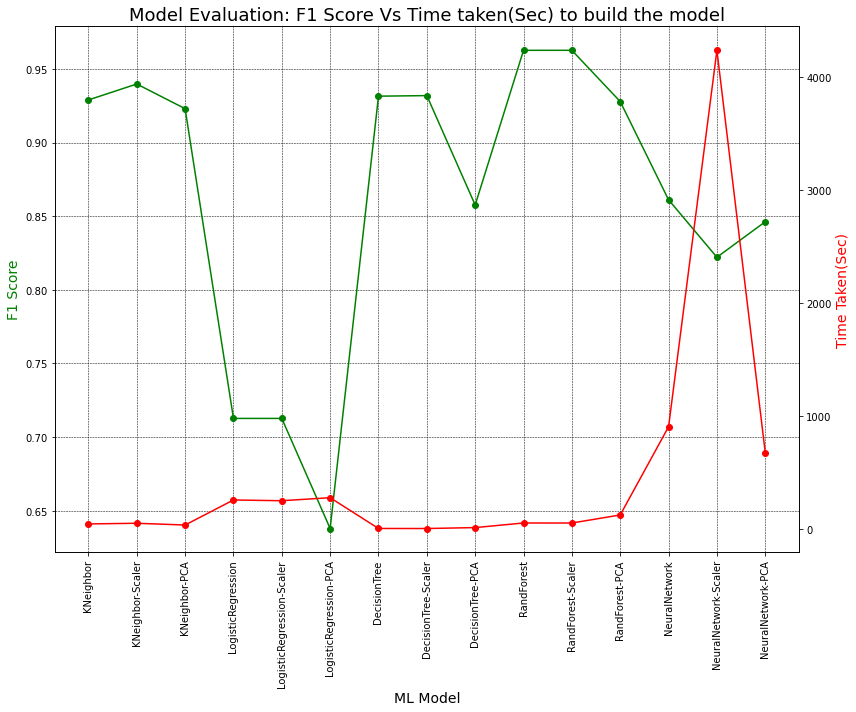

In [403]:
# create plot to compare f1 score and the time taken to build it
fig,ax = plt.subplots()
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)

# set a plot size
plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.autolayout"] = True
# make the plot
ax.plot(df_plot.xLabel, df_plot.f1_score, color="green", marker="o")
# set x-axis label
ax.set_xlabel("ML Model",fontsize=14)
# set y-axis label
ax.set_ylabel("F1 Score",color="green",fontsize=14)
plt.xticks(rotation = 90) 
# twin object for 2nd y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_plot.xLabel, df_plot["time_taken"],color="red",marker="o")
ax2.set_ylabel("Time Taken(Sec)",color="red",fontsize=14)
ax2.set_title("Model Evaluation: F1 Score Vs Time taken(Sec) to build the model",color="black",fontsize=18)

plt.show()


##  Confusion Matrix
#### Performance of our classification model on the set of test data
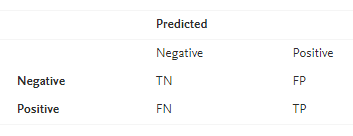

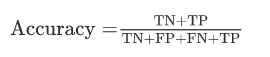

In [379]:
# Get the record with the highest F1 Score
df_sorted_Highest_f1 = df.sort_values(by='f1_score', ascending=False)
df_sorted_Highest_f1.iloc[0]

model_name                               RandomForestClassifier
model_type                                               Scaler
time_taken                                            55.641478
f1_score                                                0.96258
Predicted                                                   NaN
predicted     [2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...
xLabel                                        RandForest-Scaler
Name: 10, dtype: object

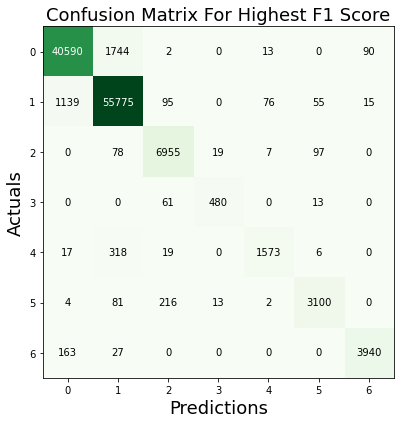

In [384]:
conf_matrix = metrics.confusion_matrix(dev_labels,df_sorted_Highest_f1.iloc[0]["predicted"])
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix For Highest F1 Score', fontsize=18)
plt.show()

In [381]:
df_sorted_Least_time = df.sort_values(by='time_taken', ascending=True)
df_sorted_Least_time.iloc[0]

model_name                               DecisionTreeClassifier
model_type                                               Scaler
time_taken                                             7.123512
f1_score                                               0.931831
Predicted                                                   NaN
predicted     [2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...
xLabel                                      DecisionTree-Scaler
Name: 7, dtype: object

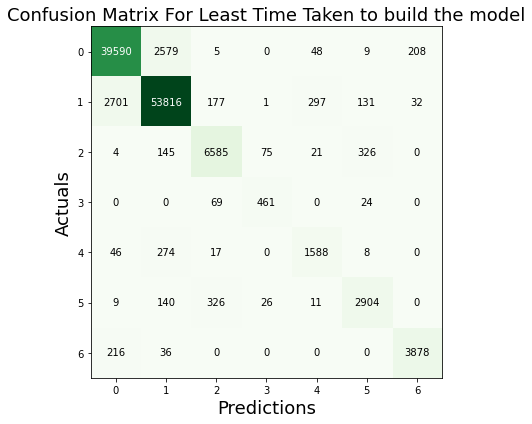

In [385]:
# Confusion Matrix for the model that took least time to build
conf_matrix = metrics.confusion_matrix(dev_labels,df_sorted_Least_time.iloc[0]["predicted"])
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix For Least Time Taken to build the model', fontsize=18)
plt.show()

In [388]:
# Model with Lowest F1 Score aka Least Accuracy
df_sorted_Highest_f1.iloc[-1]


model_name                                   LogisticRegression
model_type                                                  PCA
time_taken                                            279.87562
f1_score                                               0.637987
Predicted                                                   NaN
predicted     [2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 6.0, 1.0, ...
xLabel                                   LogisticRegression-PCA
Name: 5, dtype: object

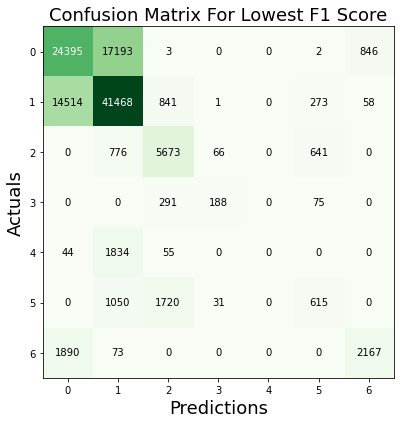

In [389]:
# Confusion matrix for model with Lowest F1 Score aka Least Accuracy
conf_matrix = metrics.confusion_matrix(dev_labels,df_sorted_Highest_f1.iloc[-1]["predicted"])
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix For Lowest F1 Score', fontsize=18)
plt.show()

In [390]:
# The model that took maximum time to build
df_sorted_Least_time.iloc[-1]

model_name                                        NeuralNetwork
model_type                                               Scaler
time_taken                                          4238.971683
f1_score                                               0.822106
Predicted                                                   NaN
predicted     [2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 6.0, 1.0, ...
xLabel                                     NeuralNetwork-Scaler
Name: 13, dtype: object

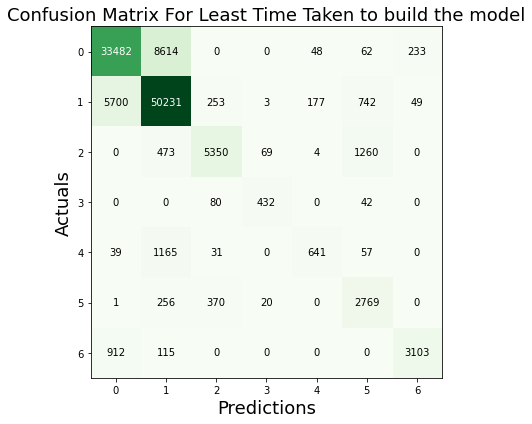

In [391]:
# Confusion Matrix for the model that took maximum time to build
conf_matrix = metrics.confusion_matrix(dev_labels,df_sorted_Least_time.iloc[-1]["predicted"])
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix For Least Time Taken to build the model', fontsize=18)
plt.show()

## Classification Report
##### Measure the quality of predictions for our classification algorithm.

###### Precision – Accuracy of positive predictions - (TP/(TP + FP))
###### Recall – What percent of the positive cases did our Model catch - TP/(TP+FN)
###### F1 score – What percent of positive predictions were correct - (2*(Recall * Precision) / (Recall + Precision))

In [396]:
print ( "\033[1m" , "Classification Report of the Model with the best F1 Score" , "\033[0;0m" )
print(metrics.classification_report(df_sorted_Highest_f1.iloc[0]["predicted"],dev_labels ))

 Classification Report of the Model with the best F1 Score 
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.96     41913
         2.0       0.98      0.96      0.97     58023
         3.0       0.97      0.95      0.96      7348
         4.0       0.87      0.94      0.90       512
         5.0       0.81      0.94      0.87      1671
         6.0       0.91      0.95      0.93      3271
         7.0       0.95      0.97      0.96      4045

    accuracy                           0.96    116783
   macro avg       0.92      0.95      0.94    116783
weighted avg       0.96      0.96      0.96    116783



In [401]:
print ( "\033[1m" , "Classification Report of the Model that took Least Time" , "\033[0;0m" )
print(metrics.classification_report(df_sorted_Least_time.iloc[0]["predicted"],dev_labels ))

 Classification Report of the Model that took Least Time 
              precision    recall  f1-score   support

         1.0       0.93      0.93      0.93     42566
         2.0       0.94      0.94      0.94     56990
         3.0       0.92      0.92      0.92      7179
         4.0       0.83      0.82      0.83       563
         5.0       0.82      0.81      0.81      1965
         6.0       0.85      0.85      0.85      3402
         7.0       0.94      0.94      0.94      4118

    accuracy                           0.93    116783
   macro avg       0.89      0.89      0.89    116783
weighted avg       0.93      0.93      0.93    116783

